In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from IPython.display import clear_output

In [2]:
import os
os.environ["TF_CPP_MIN_VLOG_LEVEL"] = "2"

In [3]:
filename = "BTC-USD.csv"

In [4]:
df=pd.read_csv("./data/" + filename)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-07-18,7315.319824,7534.990234,7280.470215,7370.779785,7370.779785,6103410176
1,2018-07-19,7378.200195,7494.459961,7295.459961,7466.859863,7466.859863,5111629824
2,2018-07-20,7467.399902,7594.669922,7323.259766,7354.129883,7354.129883,4936869888
3,2018-07-21,7352.720215,7437.640137,7262.410156,7419.290039,7419.290039,3726609920
4,2018-07-22,7417.799805,7537.950195,7383.819824,7418.490234,7418.490234,3695460096


In [5]:
roc = []
for i in range(9, len(df)):
    currentData = df.iloc[i]
    pastData = df.iloc[i - 9]
    roc.append(currentData["Close"] / pastData["Close"] * 100)
print(len(roc))

1818


In [6]:
df = df.loc[9:]

In [7]:
df["Close"] = roc

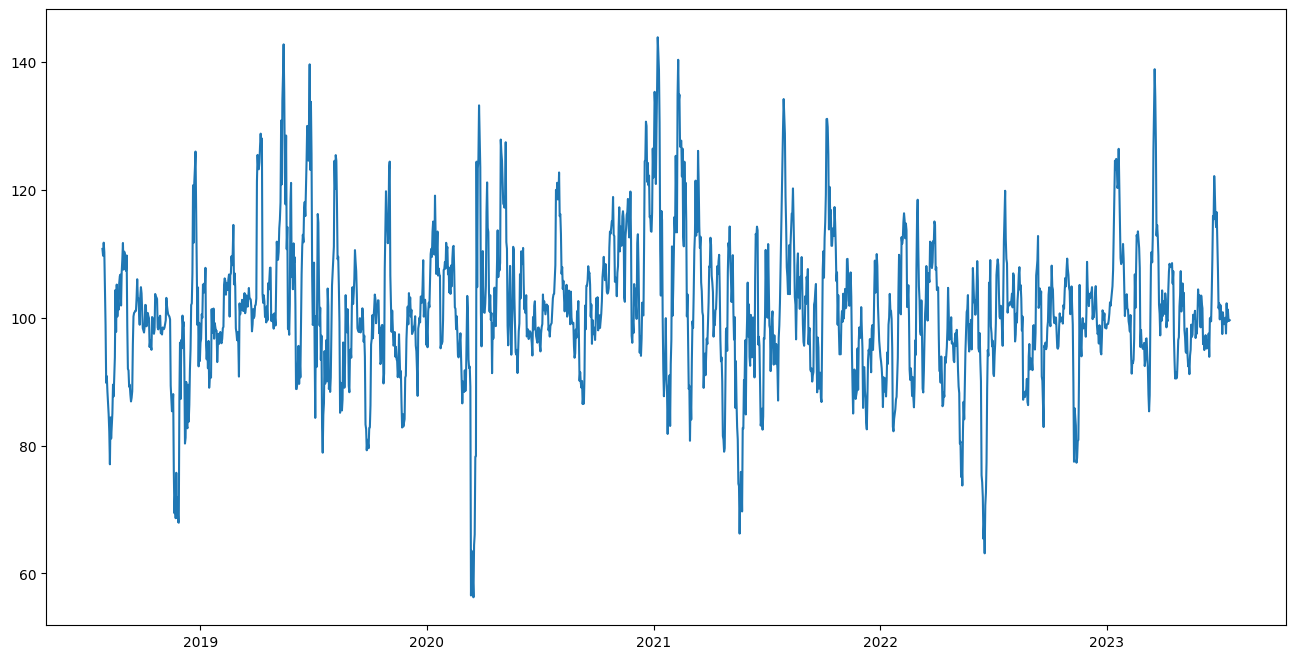

In [8]:
df["Date"]=pd.to_datetime(df.Date, format="mixed")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [9]:
data=df.sort_index(ascending=True,axis=0)
print(df.shape)

(1818, 7)


In [10]:
"""
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=datetime.timestamp(data['Date'][i])
    new_dataset["Close"][i]=data["Close"][i]
    clear_output(wait=True)
    print(str(i) + ": " + str(data['Date'][i]))
"""

'\nnew_dataset=pd.DataFrame(index=range(0,len(df)),columns=[\'Date\',\'Close\'])\nfor i in range(0,len(data)):\n    new_dataset["Date"][i]=datetime.timestamp(data[\'Date\'][i])\n    new_dataset["Close"][i]=data["Close"][i]\n    clear_output(wait=True)\n    print(str(i) + ": " + str(data[\'Date\'][i]))\n'

In [11]:
new_dataset = data.loc[:, ('Date', 'Close')]

In [12]:
new_dataset

,Date,Close
Date,,
2018-07-27,2018-07-27,110.775386
2018-07-28,2018-07-28,109.713461
2018-07-29,2018-07-29,111.752989
2018-07-30,2018-07-30,110.259606
2018-07-31,2018-07-31,104.879021
...,...,...
2023-07-14,2023-07-14,99.409790
2023-07-15,2023-07-15,101.292134
2023-07-16,2023-07-16,99.693059


In [13]:
new_dataset.index = new_dataset.Date
new_dataset.drop("Date", axis = 1, inplace = True)
print(new_dataset)

                 Close
Date                  
2018-07-27  110.775386
2018-07-28  109.713461
2018-07-29  111.752989
2018-07-30  110.259606
2018-07-31  104.879021
...                ...
2023-07-14   99.409790
2023-07-15  101.292134
2023-07-16   99.693059
2023-07-17   99.515880
2023-07-18   99.629705

[1818 rows x 1 columns]


In [14]:
scaler = MinMaxScaler(feature_range = (0, 1))
final_dataset = new_dataset.values

In [15]:
"""
dataset = new_dataset.values
final_dataset = []
for x in dataset:
    final_dataset.append([datetime.timestamp(x[0]), x[1]])
final_dataset = np.array(final_dataset)
"""

'\ndataset = new_dataset.values\nfinal_dataset = []\nfor x in dataset:\n    final_dataset.append([datetime.timestamp(x[0]), x[1]])\nfinal_dataset = np.array(final_dataset)\n'

In [16]:
print(final_dataset.shape)

(1818, 1)


In [17]:
limit = len(final_dataset) * 9 // 10
train_data = final_dataset[0 : limit,:]
valid_data = final_dataset[limit :, :]
print(train_data.shape)

(1636, 1)


In [18]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(final_dataset)

In [19]:
slide_window = 60
x_train_data,y_train_data=[],[]

for i in range(slide_window, len(train_data)):
    x_train_data.append(scaled_data[i - slide_window : i, 0])
    y_train_data.append(scaled_data[i, 0])
    
x_train_data = np.array(x_train_data)
y_train_data = np.array(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

In [20]:
inputs_data = new_dataset[len(new_dataset) - len(valid_data) - slide_window:].values
#inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
print(len(new_dataset), len(valid_data))

1818 182


In [21]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

In [22]:
lstm_model.fit(x_train_data, y_train_data, epochs=1, batch_size=1, verbose=1)

1576/1576 [==============================] - 19s 11ms/step - loss: 0.0083


In [23]:
X_test = []
for i in range(slide_window, inputs_data.shape[0]):
    X_test.append(inputs_data[i - slide_window : i, 0])
X_test = np.array(X_test)
print(X_test)

[[0.44224288 0.44929686 0.43029293 ... 0.76359437 0.78278146 0.77089338]
 [0.44929686 0.43029293 0.48762964 ... 0.78278146 0.77089338 0.73085139]
 [0.43029293 0.48762964 0.49853388 ... 0.77089338 0.73085139 0.73723424]
 ...
 [0.48687032 0.46493685 0.46881445 ... 0.52495263 0.49231153 0.51379759]
 [0.46493685 0.46881445 0.50449335 ... 0.49231153 0.51379759 0.49554491]
 [0.46881445 0.50449335 0.49686974 ... 0.51379759 0.49554491 0.49352249]]


In [24]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(182, 60, 1)


In [25]:
predicted_closing_price=lstm_model.predict(X_test)

6/6 [==============================] - 0s 7ms/step


In [26]:
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [27]:
lstm_model.save("./model/" + filename + "_roc.keras")

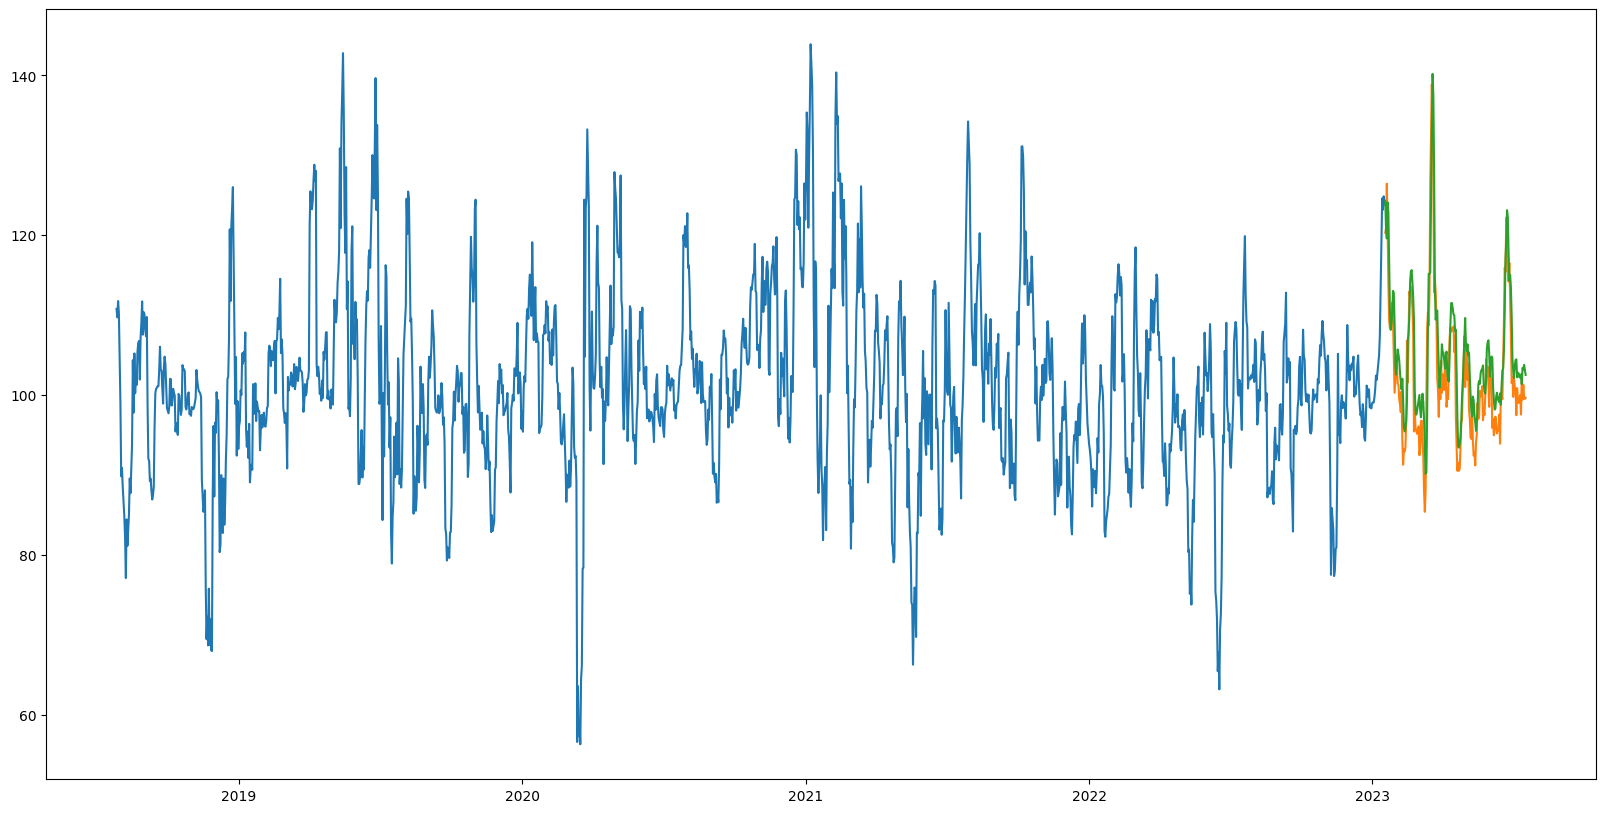

In [28]:
train_data=new_dataset[:limit]
valid_data=new_dataset[limit:]
valid_data = valid_data.loc[:, :]
valid_data['Predictions'] = predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

In [30]:
if (1==2):
    a=""
else:
    a="22"
a

'22'